# Tutorial 2: D to P Exciation in Helium

This tutorial demonstrates how to set up an excitation from a D state to a P state for Helium. The Helium D-state we are considering is now not the ground state of the atom so decay can occur to lower states. The upper P-state can also decay to other states non-radiatively which can also be modelled. In this tutorial the decay to other states is modelled. 

The use of simultaneous polarisations and the normalisation of the half-Rabi frequencies is demonstrated here as well. 


Also, the Wigner-D matrices are used to rotate the system to a different reference frame to show that this model is physically consistent in all reference frames. 

Start by importing the libraries we will be using.

In [1]:
import LASED as las
import numpy as np
from IPython.display import Image # This is to display html images in a notebook
import plotly.graph_objects as go

## Decay to Other States

To set up a Laser-Atom system you must first declare the atomic states which you want to work with and label them. We are going to set up an example system for a D-state to a P-state transistion for helium where the P-state is a high principle quantum number Rydberg state. Therefore, we will assume that the wavelength of this fictitious transition is the ionisation energy of helium as this is a very high lying Rydberg state. This system is only for example purposes only and does not exist. 

![HeRydbergDtoP](LevelDiagrams/HeRydbergDtoP.png)

A level diagram of the system we will model is shown above. 

The `LaserAtomSystem` is setup in the code block below. The decay (e.g. non-radiative decay) to other states outside the system from the excited state is characterised by the arrow from the upper states to state $|f\rangle$. This can be modelled into the `LaserAtomSystem` using the keyword `tau_f` and inputting the lifetime of this decay. The decay to other states from the lower state is shown in the diagram by the arrow from the lower state to the state $|b\rangle$. This can be modelled using the keyword `tau_b` and inputting the lifetime of this decay.

We will excite this system with simultaneous right-hand circular and left-hand circular polarised light in the natural frame with the laser beam travelling down the quantisation axis. This will be linearly-polarised light in the collision frame where the transverse E-field of the laser is oscillating along the quantisation axis. Therefore, we must set `Q = [-1, 1]` and set the `rabi_factors` to `[1, -1]` as noted in Tutorial 1 and scale the Rabi frequency in the system by using `rabi_scaling`. In this case set it to $1/{\sqrt{2}}$.

Then, we create the sub-states and put them into either the ground or excited states.

In [2]:
# System parameters
laser_wavelength = 827e-9 # wavelength of transition
w_e = las.angularFreq(laser_wavelength)

# Create states
one = las.State(label = 1, w = 0, m = -2, L = 2, S = 0)
two = las.State(label = 2, w = 0, m = -1, L = 2, S = 0)
three = las.State(label = 3, w = 0, m = 0, L = 2, S = 0)
four = las.State(label = 4, w = 0, m = 1, L = 2, S = 0)
five = las.State(label = 5, w = 0, m = 2, L = 2, S = 0)

six = las.State(label = 6, w = w_e, m = -1, L = 1, S = 0)
seven = las.State(label = 7, w = w_e, m = 0, L = 1, S = 0)
eight = las.State(label = 8, w = w_e, m = 1, L = 1, S = 0)

G = [one, two, three, four, five] # ground states
E = [six, seven, eight] # excited states
Q = [-1, 1] # laser radiation polarisation
rabi_scaling_he = 1/np.sqrt(2)
rabi_factors_he = [1, -1]
laser_intensity = 100 # mW/mm^2
tau = 100e3 # lifetime in ns (estimated)
tau_f = 1000 # non-radiative lifetime of rydberg upper state to other high-lying states (ns)
tau_b = 1000  # non-radiatuve lifetime of metastable D-state (ns)

Set the simulation time for 1000 ns every 1 ns as follows:

In [3]:
# Simulation parameters
start_time = 0
stop_time = 1000 # in ns
time_steps = 1001
time = np.linspace(start_time, stop_time, time_steps)

Create the `LaserAtomSystem` object. To set the initial conditions of the density matrix at t = 0 ns $\rho(t = 0)$ we can use the `setRho_0(s1, s2, val)` where `s1` and `s2` are `State` objects denoting the element of the density matrix to be set as $\rho_{s1,s2}$ and `val` denotes the value assigned to this element.

For this system we have set the populations of states $|1\rangle$, $|3\rangle$, and $|5\rangle$ as 1/3. So the density matrix elements $\rho_{11}$ = $\rho_{33}$ = $\rho_{55}$ = 1/3. 

In [4]:
helium_system = las.LaserAtomSystem(E, G, tau, Q, laser_wavelength, 
                                    laser_intensity = laser_intensity, rabi_scaling = rabi_scaling_he, 
                                    rabi_factors = rabi_factors_he)
helium_system_tauf = las.LaserAtomSystem(E, G, tau, Q, laser_wavelength, 
                                         tau_f = tau_f,
                                    laser_intensity = laser_intensity, rabi_scaling = rabi_scaling_he, 
                                    rabi_factors = rabi_factors_he)
helium_system_tauf_taub = las.LaserAtomSystem(E, G, tau, Q, laser_wavelength, 
                                         tau_f = tau_f, tau_b = tau_b,
                                    laser_intensity = laser_intensity, rabi_scaling = rabi_scaling_he, 
                                    rabi_factors = rabi_factors_he)
helium_system.setRho_0(one, one, 1/3)
helium_system.setRho_0(three, three, 1/3) 
helium_system.setRho_0(five, five, 1/3)
helium_system_tauf.setRho_0(one, one, 1/3)
helium_system_tauf.setRho_0(three, three, 1/3) 
helium_system_tauf.setRho_0(five, five, 1/3)
helium_system_tauf_taub.setRho_0(one, one, 1/3)
helium_system_tauf_taub.setRho_0(three, three, 1/3) 
helium_system_tauf_taub.setRho_0(five, five, 1/3)

Time evolve the system.

In [5]:
helium_system.timeEvolution(time)
helium_system_tauf.timeEvolution(time)
helium_system_tauf_taub.timeEvolution(time)

Now, we can plot the populations using `Plotly` (or any other plotting package).

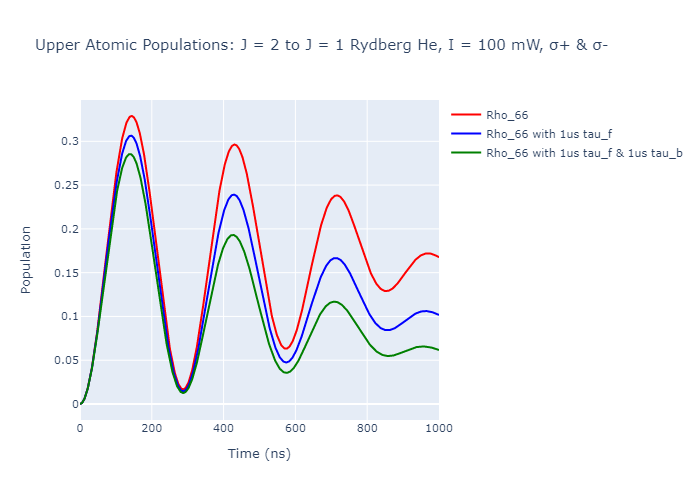

In [6]:
rho_66 = [ abs(rho) for rho in helium_system.Rho_t(six, six)]
rho_66_tauf = [abs(rho) for rho in helium_system_tauf.Rho_t(six, six)]
rho_66_tauf_taub = [abs(rho) for rho in helium_system_tauf_taub.Rho_t(six, six)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'lines',
                                    name = "Rho_66",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_66_tauf,
                                 mode = 'lines',
                                    name = "Rho_66 with 1us tau_f",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_66_tauf_taub,
                                 mode = 'lines',
                                    name = "Rho_66 with 1us tau_f & 1us tau_b",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Upper Atomic Populations: J = 2 to J = 1 Rydberg He, I = 100 mW, σ+ & σ-",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeLifetimes.png")
Image("SavedPlots/tutorial2-HeLifetimes.png")

## Rotation

With `LASED` we can rotate density matrices to different reference frames using the Wigner-D matrix. 

**Note**: The Wigner-D matrix is only defined for J-represenattion (when isospin I = 0) and therefore when in F-representation the rotation may not be correct. Also, density matrices can only be rotated for single atomic states so the optical coherences between ground and excited states cannot be rotated. To obtain optical coherences in a different reference frame the initial density matrix (at t = 0) must be rotated and time evolved with the polarisation rotated to that frame.
 
The rotation is defined by Euler angles `alpha`, `beta`, and `gamma`. The frame is rotated with each angle in succession so that:
* `alpha` is the rotation (in radians) around the initial z-axis to obtain the new frame Z'
* `beta` is the rotation (in radians) about the new y'-axis to obtain the new frame Z''
* `gamma` is the rotation (in radians) about the new z''-axis to obtain the final frame

In `LASED` to rotate the initial density matrix use `rotateRho_0(alpha, beta, gamma)` on the `LaserAtomSystem`. In this he lium system the atom is changed to be defined in the collision frame from the natural frame so the polarisation is changed to be purely linear with `Q = [0]` and scaled to 1.

**Note**: To simulate a linear polarisation with an angle with respect to the x-axis we can initialise the density matrix in that frame, rotate to the collision frame (with the polarisation aligned with the x-axis, time evolve the system, and then rotate back to the frame where the polarisation is at an angle.

In [7]:
alpha = np.pi/2
beta = np.pi/2
gamma = -np.pi/2
helium_system_rot = helium_system
helium_system_rot.rotateRho_0(alpha, beta, gamma)
helium_system_rot.Q = [0]
helium_system.rabi_scaling = 1
helium_system.rabi_factors = [1]

Now, we can time evolve this system in this new reference frame.

In [8]:
print(helium_system_rot)
helium_system_rot.timeEvolution(time)

LaserAtomSystem([6, 7, 8], [1, 2, 3, 4, 5], 100000.0, [0], [1, 0, -1], 8.27e-07, None, 100, None)


Now we can plot what the populations look like.

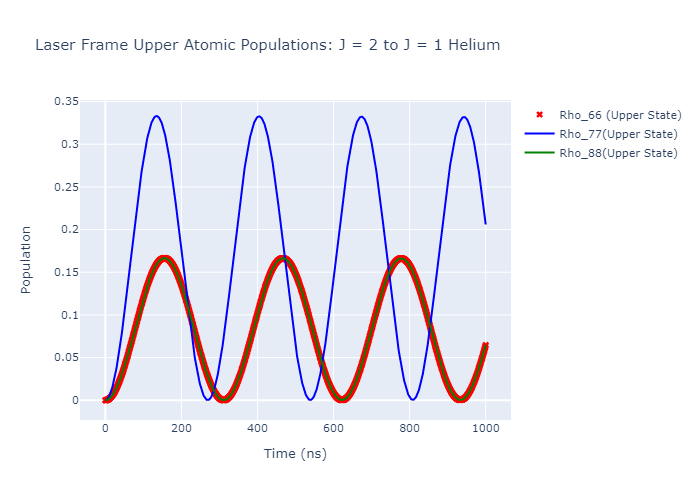

In [9]:
las_sys = helium_system_rot
rho_66 = [ abs(rho) for rho in las_sys.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in las_sys.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in las_sys.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Laser Frame Upper Atomic Populations: J = 2 to J = 1 Helium",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeFigUpperCollFrame.png")
Image("SavedPlots/tutorial2-HeFigUpperCollFrame.png")

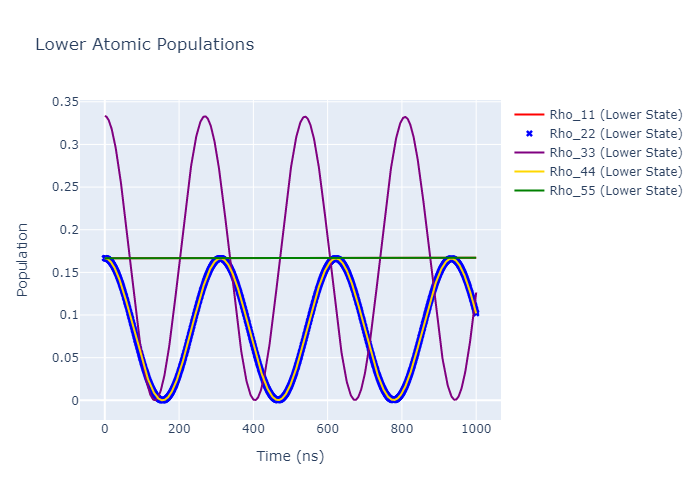

In [10]:
rho11 = [ abs(rho) for rho in las_sys.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in las_sys.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in las_sys.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in las_sys.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in las_sys.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations",
                        xaxis_title = "Time (ns)",
                 yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial2-HeFigLowerCollFrame.png")
Image("SavedPlots/tutorial2-HeFigLowerCollFrame.png")

If we rotate the time-evolved density matrix `rho_t` back to the natural frame we should get the same populations as when we evolved in the natural frame as the excitation must be the same in all reference frames. We can do this rotation by using `rotateRho_t` on the `LaserAtomSystem`.

**Note**: A message will be thrown saying that the optical coherences are not rotated.

In [11]:
helium_system_rot.rotateRho_t(alpha, -beta, gamma)
print("Natural Frame final populations")

Optical coherences are preserved under rotation. To obtain these in a new reference frame, rotate rho_0 and then evolve in the new reference frame with the correct polarisation.
Natural Frame final populations


Now we can plot the results and obtain the same plots as in the first time evolution.

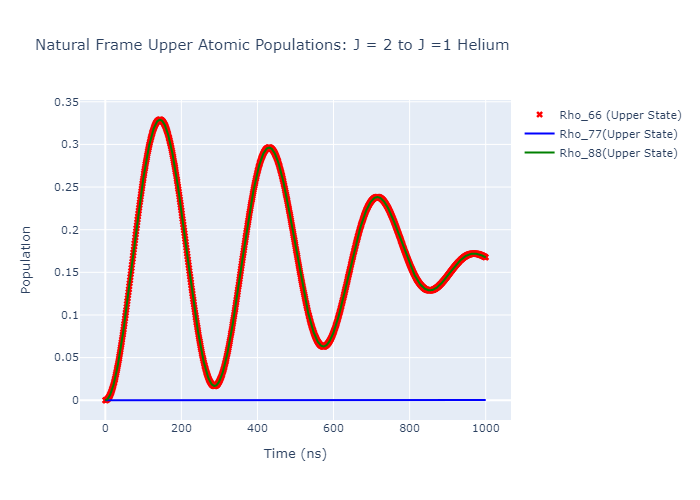

In [12]:
las_sys = helium_system_rot
rho_66 = [ abs(rho) for rho in las_sys.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in las_sys.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in las_sys.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Natural Frame Upper Atomic Populations: J = 2 to J =1 Helium",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeFigUpperRotatedToNatFrame.png")
Image("SavedPlots/tutorial2-HeFigUpperRotatedToNatFrame.png")

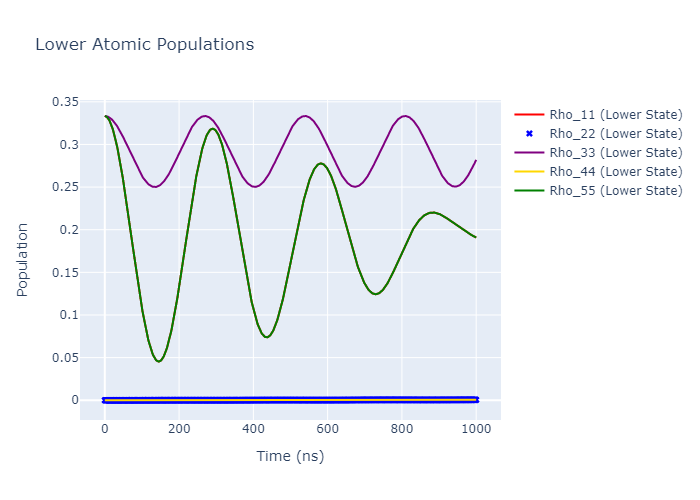

In [13]:
rho11 = [ abs(rho) for rho in las_sys.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in las_sys.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in las_sys.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in las_sys.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in las_sys.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations",
                        xaxis_title = "Time (ns)",
                 yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial2-HeFigLowerRotatedToNatFrame.png")
Image("SavedPlots/tutorial2-HeFigLowerRotatedToNatFrame.png")